In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_fscore_support

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import joblib
import pickle
import datetime

In [2]:
# Classification Models
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.ensemble import (AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, 
                              VotingClassifier, GradientBoostingClassifier, BaggingClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import time
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import (mean_squared_error, 
    r2_score, accuracy_score, mean_squared_error, 
    f1_score, precision_score, recall_score, 
    roc_auc_score, mean_absolute_error, roc_curve, 
    auc, average_precision_score, 
    precision_recall_curve, fbeta_score)
from sklearn.metrics import (confusion_matrix, 
    ConfusionMatrixDisplay, classification_report, 
    RocCurveDisplay, PrecisionRecallDisplay)
from mlxtend.plotting import plot_confusion_matrix

DATA LOADING AND MERGING

In [3]:
# Load datasets
flights_df = pd.read_csv(r"C:\Users\USER\OneDrive\Dokumen\Semester 4\AOL Data Analytics - Semester 4\Dataset\US_flights_2023.csv")
weather_df = pd.read_csv(r"C:\Users\USER\OneDrive\Dokumen\Semester 4\AOL Data Analytics - Semester 4\Dataset\weather_meteo_by_airport.csv")
location_df = pd.read_csv(r"C:\Users\USER\OneDrive\Dokumen\Semester 4\AOL Data Analytics - Semester 4\Dataset\airports_geolocation.csv")

In [4]:
# Datasets Visualization
print("Columns in flights_df:", flights_df.columns)
print("-"*80)
print("Columns in weather_df:", weather_df.columns)
print("-"*80)
print("Columns in location_df:", location_df.columns)

Columns in flights_df: Index(['FlightDate', 'Day_Of_Week', 'Airline', 'Tail_Number', 'Dep_Airport',
       'Dep_CityName', 'DepTime_label', 'Dep_Delay', 'Dep_Delay_Tag',
       'Dep_Delay_Type', 'Arr_Airport', 'Arr_CityName', 'Arr_Delay',
       'Arr_Delay_Type', 'Flight_Duration', 'Distance_type', 'Delay_Carrier',
       'Delay_Weather', 'Delay_NAS', 'Delay_Security', 'Delay_LastAircraft',
       'Manufacturer', 'Model', 'Aicraft_age'],
      dtype='object')
--------------------------------------------------------------------------------
Columns in weather_df: Index(['time', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres',
       'airport_id'],
      dtype='object')
--------------------------------------------------------------------------------
Columns in location_df: Index(['IATA_CODE', 'AIRPORT', 'CITY', 'STATE', 'COUNTRY', 'LATITUDE',
       'LONGITUDE'],
      dtype='object')


In [5]:
# Merging the dataset
merged_df = pd.merge(flights_df, weather_df,
                     how='left',
                     left_on=['Dep_Airport', 'FlightDate'],
                     right_on=['airport_id', 'time'])

final_df = pd.merge(merged_df, location_df,
                    how='left',
                    left_on=['Dep_Airport'],
                    right_on=['IATA_CODE'])

print(merged_df.columns)
print("-"*80)
print(final_df.columns)
print("-"*80)

Index(['FlightDate', 'Day_Of_Week', 'Airline', 'Tail_Number', 'Dep_Airport',
       'Dep_CityName', 'DepTime_label', 'Dep_Delay', 'Dep_Delay_Tag',
       'Dep_Delay_Type', 'Arr_Airport', 'Arr_CityName', 'Arr_Delay',
       'Arr_Delay_Type', 'Flight_Duration', 'Distance_type', 'Delay_Carrier',
       'Delay_Weather', 'Delay_NAS', 'Delay_Security', 'Delay_LastAircraft',
       'Manufacturer', 'Model', 'Aicraft_age', 'time', 'tavg', 'tmin', 'tmax',
       'prcp', 'snow', 'wdir', 'wspd', 'pres', 'airport_id'],
      dtype='object')
--------------------------------------------------------------------------------
Index(['FlightDate', 'Day_Of_Week', 'Airline', 'Tail_Number', 'Dep_Airport',
       'Dep_CityName', 'DepTime_label', 'Dep_Delay', 'Dep_Delay_Tag',
       'Dep_Delay_Type', 'Arr_Airport', 'Arr_CityName', 'Arr_Delay',
       'Arr_Delay_Type', 'Flight_Duration', 'Distance_type', 'Delay_Carrier',
       'Delay_Weather', 'Delay_NAS', 'Delay_Security', 'Delay_LastAircraft',
       'Manufa

DATA BALANCING
- Menggunakan undersampling untuk menyeimbangkan jumlah data antara 0(tidak delay) dan 1(delay)

Dep_Delay_Tag
0    200000
1    200000
Name: count, dtype: int64

Tipe data kolom Dep_Delay_Tag: int32


C:\Users\USER\AppData\Local\Temp\ipykernel_13592\48523782.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='viridis')


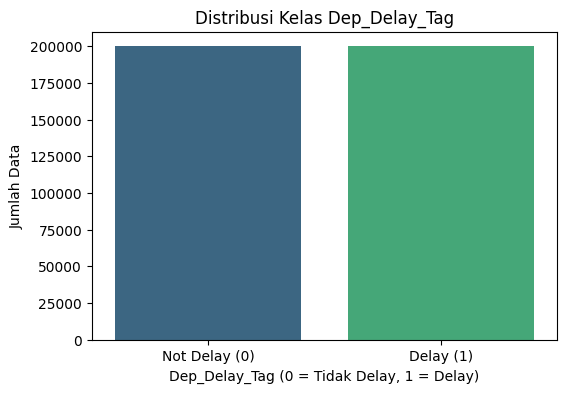

In [6]:
# Memisah data menjadi 2 bagian (0 & 1)
class_0 = final_df[final_df["Dep_Delay_Tag"] == 0] #not delay
class_1 = final_df[final_df['Dep_Delay_Tag'] == 1] #delay

min_count = 200000

class_0_sample = class_0.sample(n=min_count, random_state=42)
class_1_sample = class_1.sample(n=min_count, random_state=42)

balanced_df = pd.concat([class_0_sample, class_1_sample])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_df["Dep_Delay_Tag"] = balanced_df["Dep_Delay_Tag"].astype("int32")

print(balanced_df["Dep_Delay_Tag"].value_counts())
print("\nTipe data kolom Dep_Delay_Tag:", balanced_df["Dep_Delay_Tag"].dtype)

plt.figure(figsize=(6,4))
counts = balanced_df["Dep_Delay_Tag"].value_counts()
sns.barplot(x=counts.index, y=counts.values, palette='viridis')
plt.title("Distribusi Kelas Dep_Delay_Tag")
plt.xlabel("Dep_Delay_Tag (0 = Tidak Delay, 1 = Delay)")
plt.ylabel("Jumlah Data")
plt.xticks([0, 1], ["Not Delay (0)", "Delay (1)"])
plt.show()

In [7]:
# Mendata kolom numerical dan kategorikal
numerical_columns = [column for column in balanced_df.columns if balanced_df[column].dtype in ["float64", "float32", "int64", "int32"]]
categorical_columns = [column for column in balanced_df.columns if balanced_df[column].dtype == "object"]

print("Numerical Columns:")
for col in numerical_columns:
    print(f"- {col}")
print(f"Total: {len(numerical_columns)}\n")

print("Categorical Columns:")
for col in categorical_columns:
    print(f"- {col}")
print(f"Total: {len(categorical_columns)}")


Numerical Columns:
- Day_Of_Week
- Dep_Delay
- Dep_Delay_Tag
- Arr_Delay
- Flight_Duration
- Delay_Carrier
- Delay_Weather
- Delay_NAS
- Delay_Security
- Delay_LastAircraft
- Aicraft_age
- tavg
- tmin
- tmax
- prcp
- snow
- wdir
- wspd
- pres
- LATITUDE
- LONGITUDE
Total: 21

Categorical Columns:
- FlightDate
- Airline
- Tail_Number
- Dep_Airport
- Dep_CityName
- DepTime_label
- Dep_Delay_Type
- Arr_Airport
- Arr_CityName
- Arr_Delay_Type
- Distance_type
- Manufacturer
- Model
- time
- airport_id
- IATA_CODE
- AIRPORT
- CITY
- STATE
- COUNTRY
Total: 20


DATA CLEANING

In [8]:
balanced_df["FlightDate"] = pd.to_datetime(balanced_df["FlightDate"])  # type: ignore
balanced_df["FlightDate"].head()

balanced_df["Month"] = balanced_df["FlightDate"].dt.month
balanced_df["Day"] = balanced_df["FlightDate"].dt.day
balanced_df["Quarter"] = balanced_df["FlightDate"].dt.quarter

In [9]:
print(balanced_df.columns)
balanced_df.head(10)

Index(['FlightDate', 'Day_Of_Week', 'Airline', 'Tail_Number', 'Dep_Airport',
       'Dep_CityName', 'DepTime_label', 'Dep_Delay', 'Dep_Delay_Tag',
       'Dep_Delay_Type', 'Arr_Airport', 'Arr_CityName', 'Arr_Delay',
       'Arr_Delay_Type', 'Flight_Duration', 'Distance_type', 'Delay_Carrier',
       'Delay_Weather', 'Delay_NAS', 'Delay_Security', 'Delay_LastAircraft',
       'Manufacturer', 'Model', 'Aicraft_age', 'time', 'tavg', 'tmin', 'tmax',
       'prcp', 'snow', 'wdir', 'wspd', 'pres', 'airport_id', 'IATA_CODE',
       'AIRPORT', 'CITY', 'STATE', 'COUNTRY', 'LATITUDE', 'LONGITUDE', 'Month',
       'Day', 'Quarter'],
      dtype='object')


FlightDate  Day_Of_Week                 Airline Tail_Number Dep_Airport  \
0 2023-12-22            5  Frontier Airlines Inc.      N353FR         MCO   
1 2023-12-27            3  American Airlines Inc.      N977NN         AUS   
2 2023-10-24            2  Southwest Airlines Co.      N222WN         BUR   
3 2023-10-04            3        Republic Airways      N424YX         CVG   
4 2023-04-17            1         JetBlue Airways      N523JB         MSY   
5 2023-03-20            1            PSA Airlines      N549NN         CLT   
6 2023-05-12            5     Delta Air Lines Inc      N885DN         DTW   
7 2023-02-04            6     Delta Air Lines Inc      N822DN         SLC   
8 2023-12-12            2     Delta Air Lines Inc      N301DV         DCA   
9 2023-10-27            5    Alaska Airlines Inc.      N514AS         SEA   

         Dep_CityName DepTime_label  Dep_Delay  Dep_Delay_Tag Dep_Delay_Type  \
0         Orlando, FL       Evening         -7              0      Low <5min   
1          Austin, TX       Morning         -2              0      Low <5min   
2         Burbank, CA     Afternoon         -8              0      Low <5min   
3      Cincinnati, OH       Morning         -9              0      Low <5min   
4     New Orleans, LA       Morning          4              1      Low <5min   
5       Charlotte, NC     Afternoon         -6              0      Low <5min   
6         Detroit, MI     Afternoon         27              1  Medium >15min   
7  Salt Lake City, UT       Morning         -5              0      Low <5min   
8      Washington, DC       Morning         -3              0      Low <5min   
9         Seattle, WA     Afternoon         36              1  Medium >15min   

   ... IATA_CODE                                            AIRPORT  \
0  ...       MCO                      Orlando International Airport   
1  ...       AUS             Austin-Bergstrom International Airport   
2  ...       BUR       Bob Hope Airport (Hollywood Burbank Airport)   
3  ...       CVG  Cincinnati/Northern Kentucky International Air...   
4  ...       MSY  Louis Armstrong New Orleans International Airport   
5  ...       CLT            Charlotte Douglas International Airport   
6  ...       DTW                       Detroit Metropolitan Airport   
7  ...       SLC               Salt Lake City International Airport   
8  ...       DCA          Ronald Reagan Washington National Airport   
9  ...       SEA               Seattle-Tacoma International Airport   

             CITY STATE  COUNTRY  LATITUDE  LONGITUDE  Month  Day  Quarter  
0         Orlando    FL      USA  28.42889  -81.31603     12   22        4  
1          Austin    TX      USA  30.19453  -97.66987     12   27        4  
2         Burbank    CA      USA  34.20062 -118.35850     10   24        4  
3       Covington    KY      USA  39.04614  -84.66217     10    4        4  
4     New Orleans    LA      USA  29.99339  -90.25803      4   17        2  
5       Charlotte    NC      USA  35.21401  -80.94313      3   20        1  
6         Detroit    MI      USA  42.21206  -83.34884      5   12        2  
7  Salt Lake City    UT      USA  40.78839 -111.97777      2    4        1  
8       Arlington    VA      USA  38.85208  -77.03772     12   12        4  
9         Seattle    WA      USA  47.44898 -122.30931     10   27        4  

[10 rows x 44 columns]

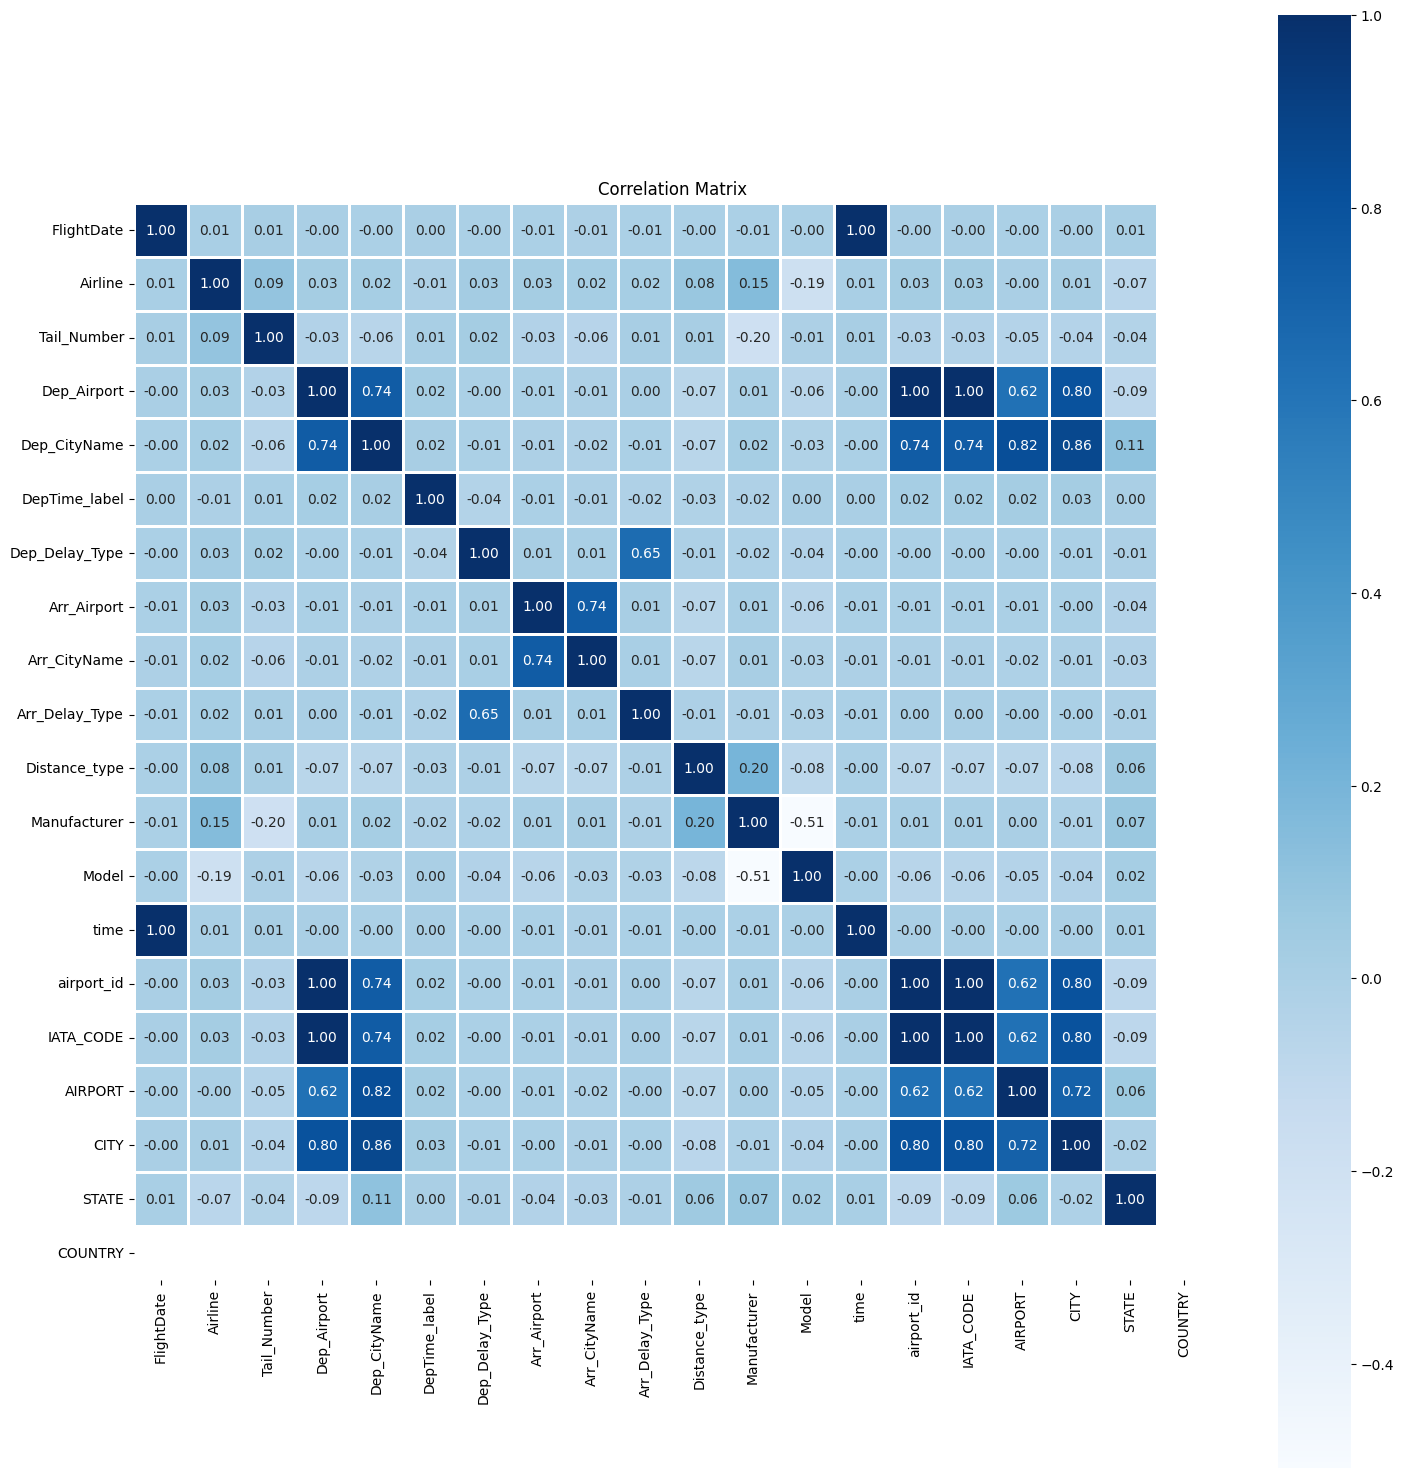

In [10]:
from sklearn.preprocessing import LabelEncoder
# Salin dataframe
encoded_df = balanced_df.copy()

# Label encode semua kolom kategorikal
le = LabelEncoder()
for col in categorical_columns:
    encoded_df[col] = le.fit_transform(encoded_df[col])

corr_matrix_cat = encoded_df[categorical_columns].corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix_cat, annot=True, cmap="Blues", linewidths=1, square=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()



<Figure size 640x480 with 0 Axes>

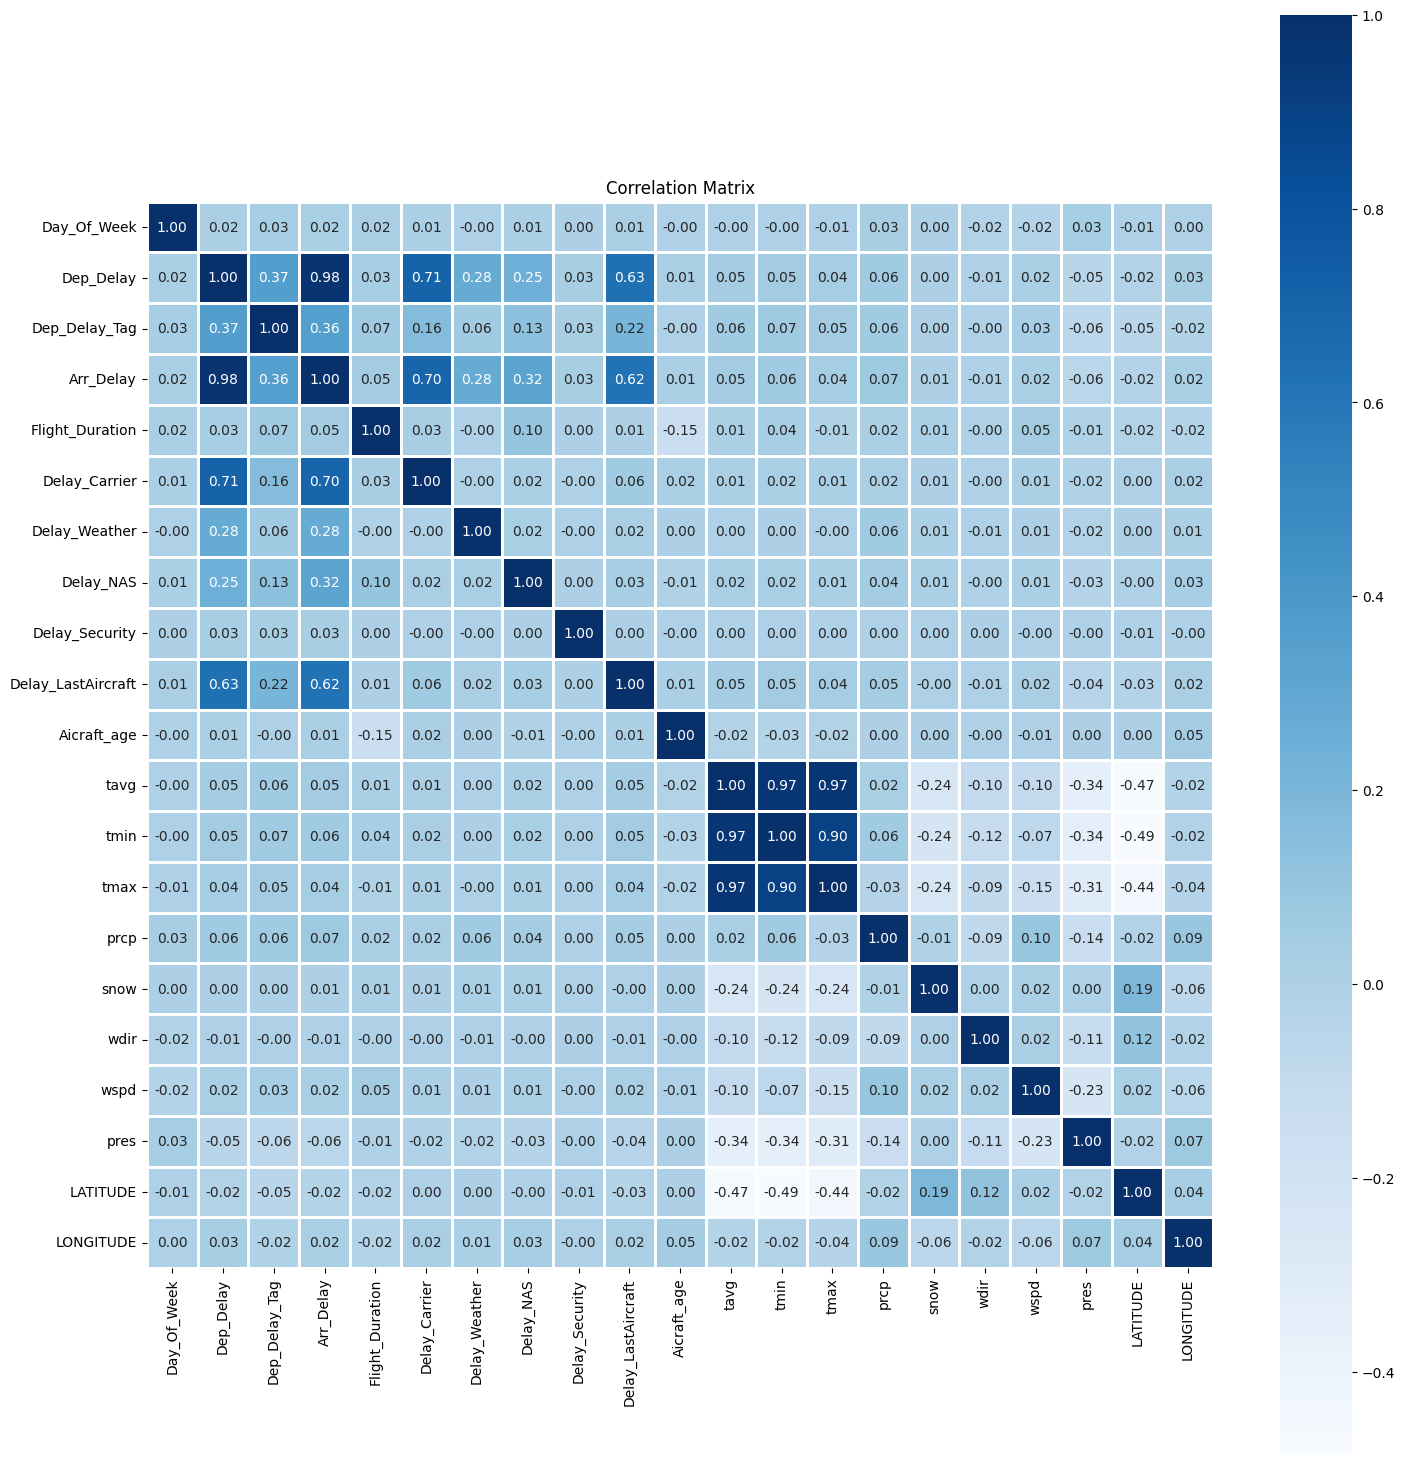

<Figure size 640x480 with 0 Axes>

In [11]:
correlation_matrix = balanced_df[numerical_columns].corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", linewidths=1, square=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.figure()

<Figure size 640x480 with 0 Axes>

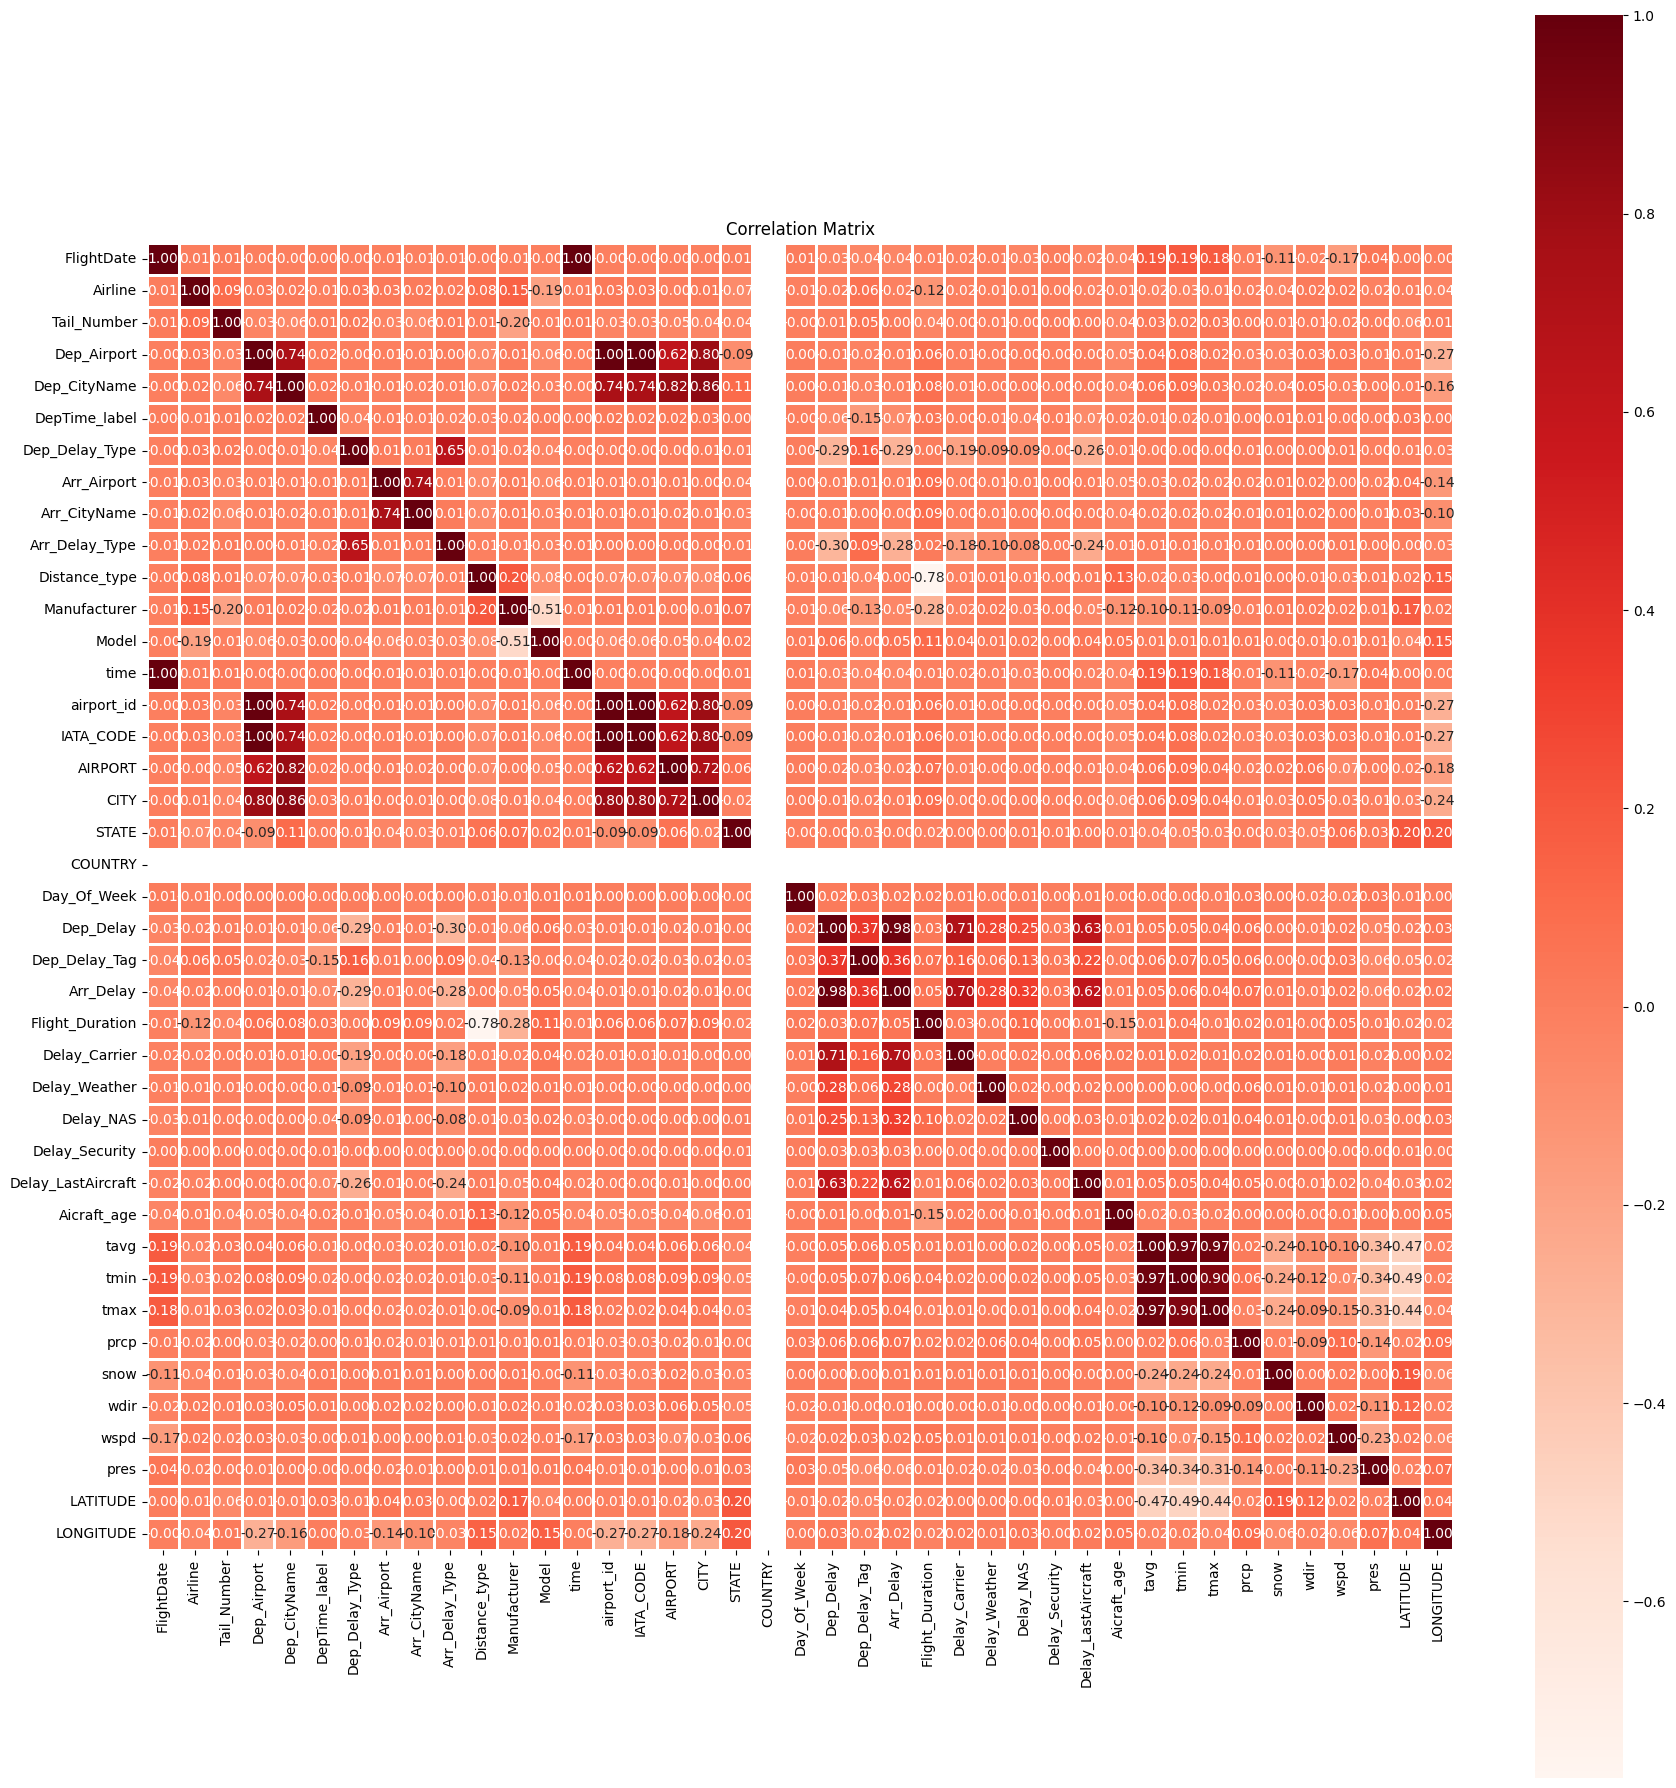

<Figure size 640x480 with 0 Axes>

In [12]:
selected_columns = categorical_columns + numerical_columns
mixed_col_corr = encoded_df[selected_columns].corr()

plt.figure(figsize=(18,18))
sns.heatmap(mixed_col_corr, annot=True, cmap="Reds", linewidths=1, square=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.figure()

Correlation (Categorical)

In [13]:
from scipy.stats import chi2_contingency
cat_corr = pd.DataFrame(columns=["Feature","Cramer's V", "Chi-Square", "P-Value"])

# Membuat COntigency Table
for col in categorical_columns:
    contingency_table = pd.crosstab(balanced_df[col], balanced_df['Dep_Delay_Tag'])

    chi2, p, dof, expected = chi2_contingency(contingency_table)

    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape)-1)))

    # Membuat dataframe sementara
    temp_df = pd.DataFrame({
        "Feature": [col],
        "Chi-Square": [chi2],
        "P-Value": [p],
        "Cramer's V": [cramers_v]
    })
    
    cat_corr = pd.concat([cat_corr, temp_df], ignore_index=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_13592\484936756.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cat_corr = pd.concat([cat_corr, temp_df], ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_13592\484936756.py:11: RuntimeWarning: invalid value encountered in divide
  cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape)-1)))


In [14]:
cat_corr

Feature  Cramer's V     Chi-Square        P-Value
0       FlightDate    0.177531   12606.849670   0.000000e+00
1          Airline    0.214923   18476.827469   0.000000e+00
2      Tail_Number    0.263738   27823.124640   0.000000e+00
3      Dep_Airport    0.161845   10477.498852   0.000000e+00
4     Dep_CityName    0.157112    9873.614672   0.000000e+00
5    DepTime_label    0.191702   14699.810410   0.000000e+00
6   Dep_Delay_Type    0.594879  141552.291951   0.000000e+00
7      Arr_Airport    0.131765    6944.831584   0.000000e+00
8     Arr_CityName    0.122696    6021.742304   0.000000e+00
9   Arr_Delay_Type    0.508429  103400.056637   0.000000e+00
10   Distance_type    0.044678     798.460416  4.135459e-174
11    Manufacturer    0.165479   10953.335854   0.000000e+00
12           Model    0.182787   13364.479956   0.000000e+00
13            time    0.177531   12606.849670   0.000000e+00
14      airport_id    0.161845   10477.498852   0.000000e+00
15       IATA_CODE    0.161845   10477.498852   0.000000e+00
16         AIRPORT    0.161769   10467.649363   0.000000e+00
17            CITY    0.156601    9809.542939   0.000000e+00
18           STATE    0.125004    6250.405261   0.000000e+00
19         COUNTRY         NaN       0.000000   1.000000e+00

<Figure size 1000x1000 with 0 Axes>

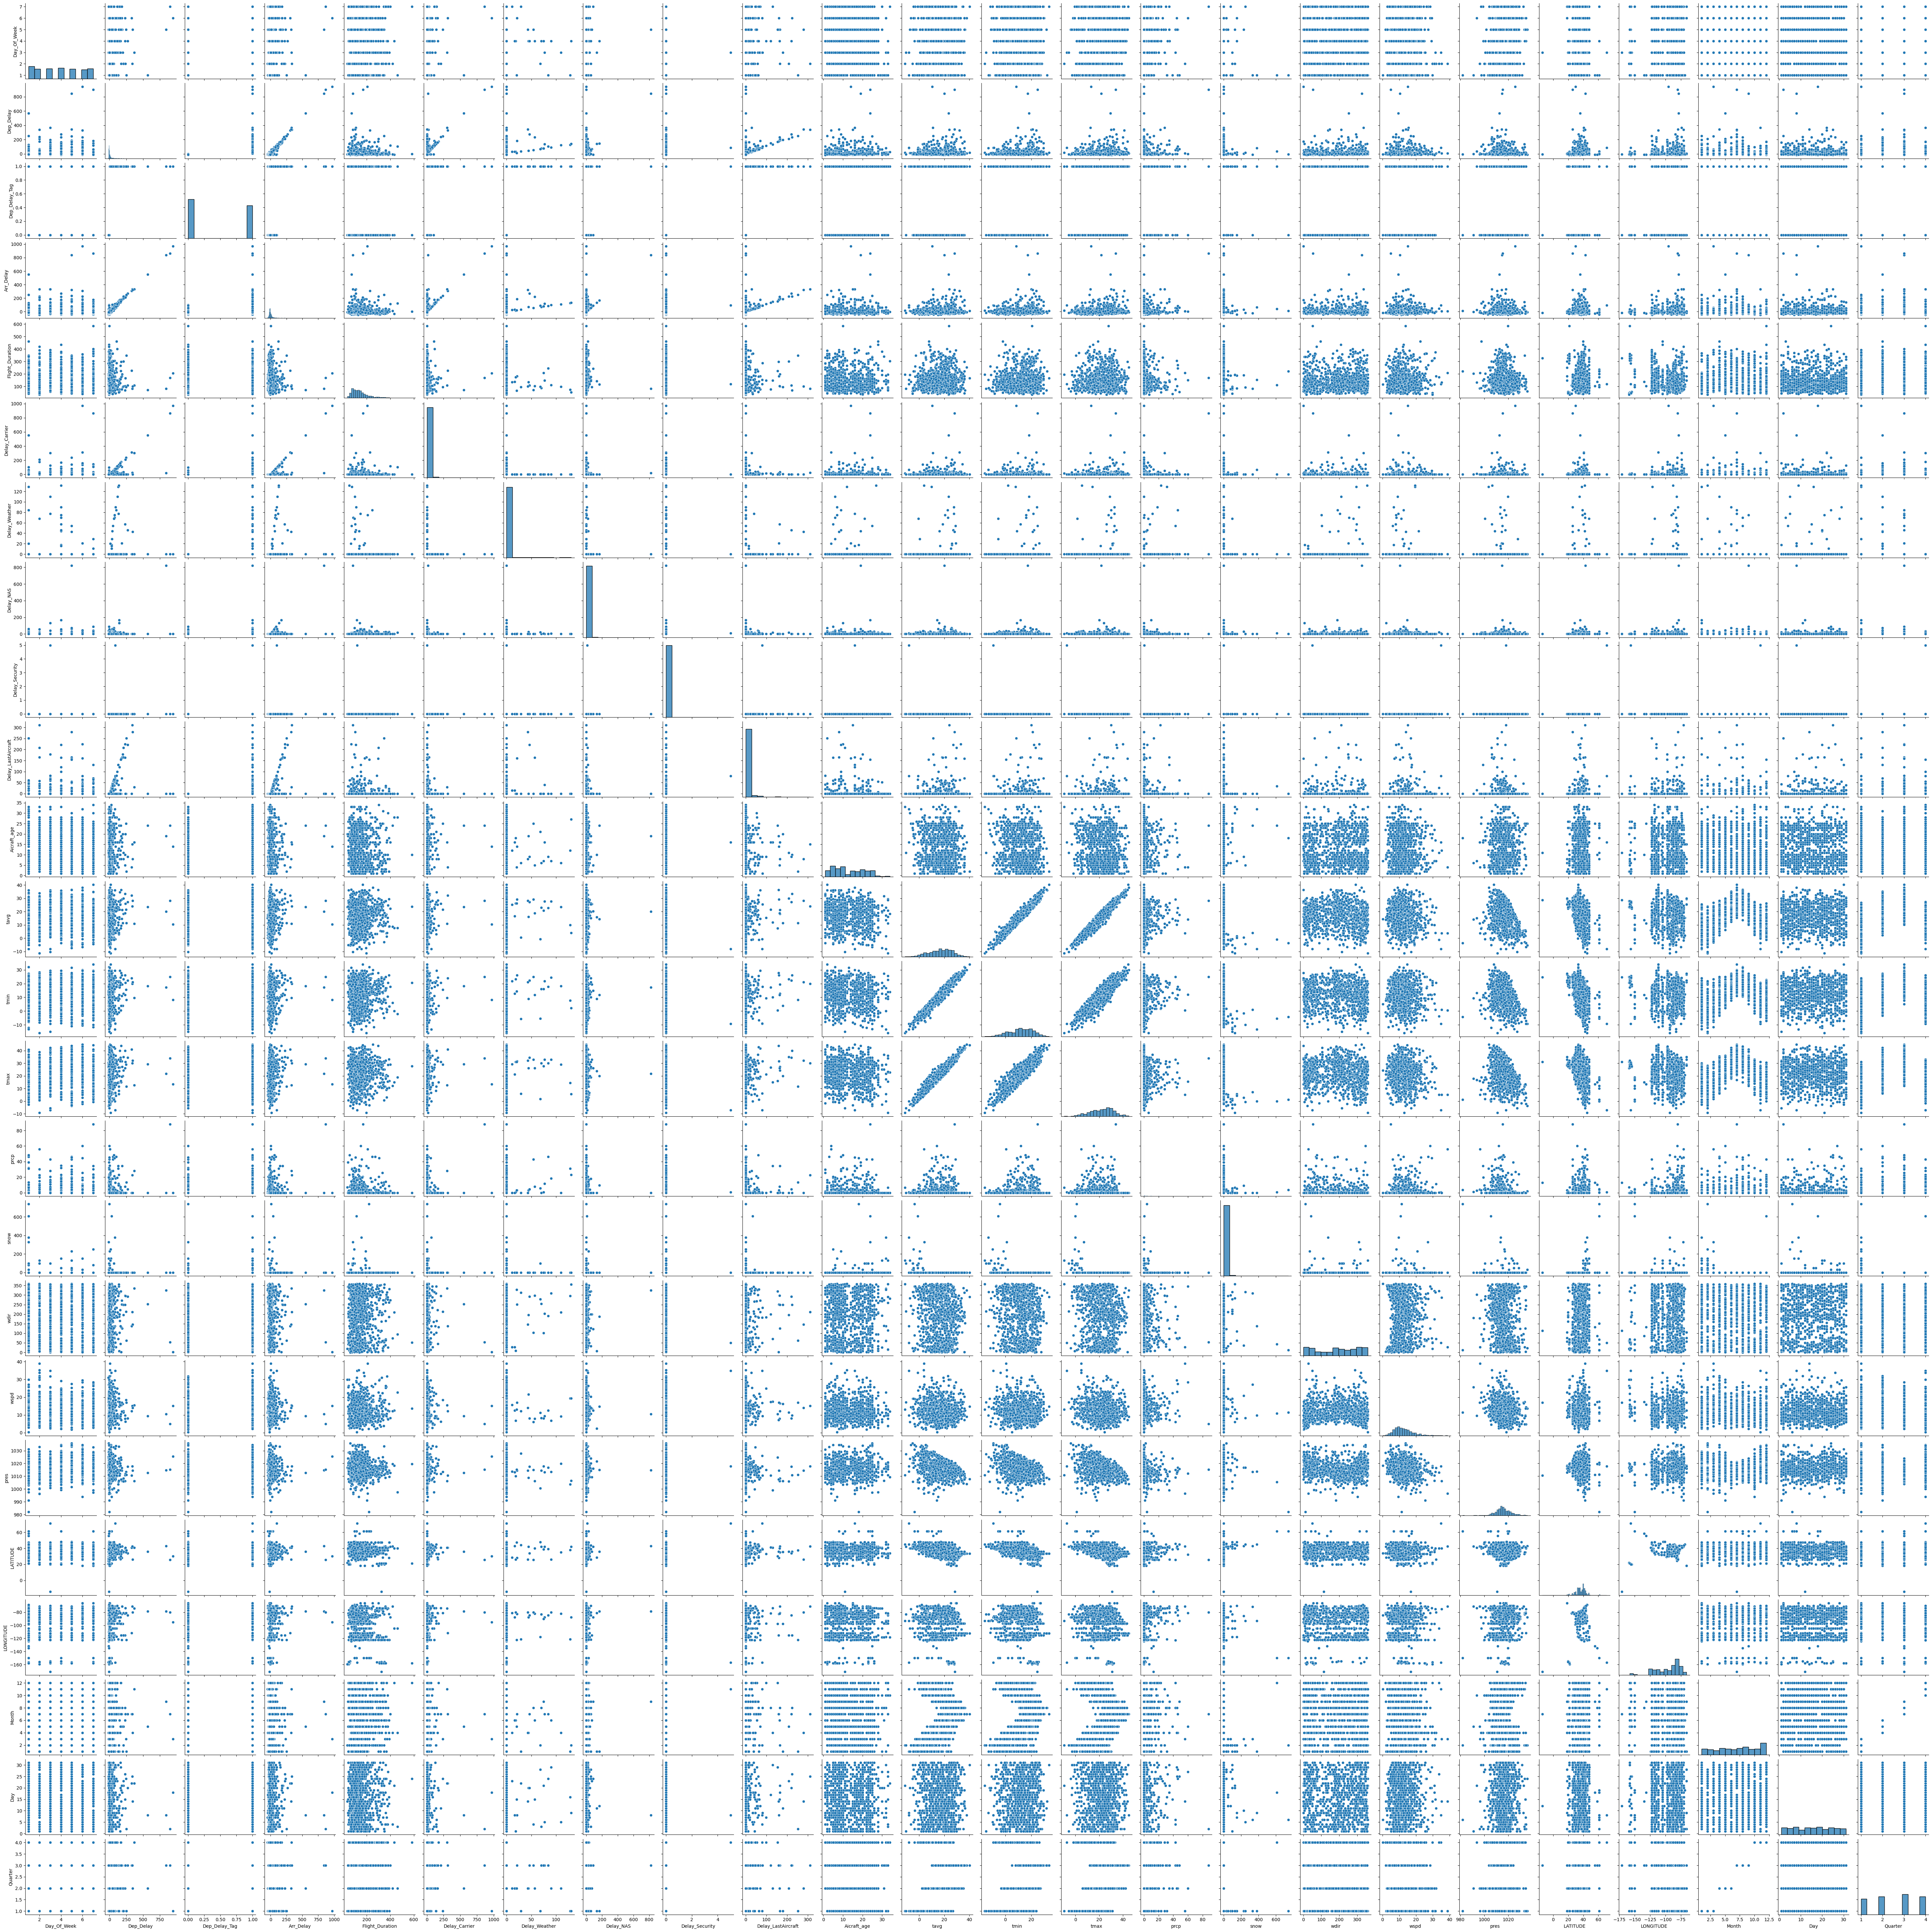

In [15]:
plt.figure(figsize=(10,10))
sns.pairplot(balanced_df.sample(1000))
plt.show()

Data Cleaning

In [16]:
# Drop column dikarenakan sudah tidak diperlukan setelah proses merging
columns_to_drop = [
    "airport_id", "IATA_CODE", "AIRPOTY", "CITY",
    "Tail_Number", "Dep_CityName", "STATE", "COUNTRY",
     "Arr_Delay", "Delay_Carrier", "Delay_NAS", "Delay_Security", "Delay_Weather",
    "Delay_LastAircraft", "tmin", "tmax", "Aircraft_age", "wdir", "wpgt", "pres",
    "LATITUDE", "LONGITUDE","Dep_Delay", "Model", "FlightDate"
]

existing_columns = [col for col in columns_to_drop if col in balanced_df.columns]
df = balanced_df.drop(columns=existing_columns)
df.columns

Index(['Day_Of_Week', 'Airline', 'Dep_Airport', 'DepTime_label',
       'Dep_Delay_Tag', 'Dep_Delay_Type', 'Arr_Airport', 'Arr_CityName',
       'Arr_Delay_Type', 'Flight_Duration', 'Distance_type', 'Manufacturer',
       'Aicraft_age', 'time', 'tavg', 'prcp', 'snow', 'wspd', 'AIRPORT',
       'Month', 'Day', 'Quarter'],
      dtype='object')

In [17]:
# Menampilkan data boolean yang memiliki nilai True elemen yang hilang dan False untuk elemen yang tidak hilang.
df.isna()

Day_Of_Week  Airline  Dep_Airport  DepTime_label  Dep_Delay_Tag  \
0             False    False        False          False          False   
1             False    False        False          False          False   
2             False    False        False          False          False   
3             False    False        False          False          False   
4             False    False        False          False          False   
...             ...      ...          ...            ...            ...   
399995        False    False        False          False          False   
399996        False    False        False          False          False   
399997        False    False        False          False          False   
399998        False    False        False          False          False   
399999        False    False        False          False          False   

        Dep_Delay_Type  Arr_Airport  Arr_CityName  Arr_Delay_Type  \
0                False        False         False           False   
1                False        False         False           False   
2                False        False         False           False   
3                False        False         False           False   
4                False        False         False           False   
...                ...          ...           ...             ...   
399995           False        False         False           False   
399996           False        False         False           False   
399997           False        False         False           False   
399998           False        False         False           False   
399999           False        False         False           False   

        Flight_Duration  ...  Aicraft_age   time   tavg   prcp   snow   wspd  \
0                 False  ...        False  False  False  False  False  False   
1                 False  ...        False  False  False  False  False  False   
2                 False  ...        False  False  False  False  False  False   
3                 False  ...        False  False  False  False  False  False   
4                 False  ...        False  False  False  False  False  False   
...                 ...  ...          ...    ...    ...    ...    ...    ...   
399995            False  ...        False  False  False  False  False  False   
399996            False  ...        False  False  False  False  False  False   
399997            False  ...        False  False  False  False  False  False   
399998            False  ...        False  False  False  False  False  False   
399999            False  ...        False  False  False  False  False  False   

        AIRPORT  Month    Day  Quarter  
0         False  False  False    False  
1         False  False  False    False  
2         False  False  False    False  
3         False  False  False    False  
4         False  False  False    False  
...         ...    ...    ...      ...  
399995    False  False  False    False  
399996    False  False  False    False  
399997    False  False  False    False  
399998    False  False  False    False  
399999    False  False  False    False  

[400000 rows x 22 columns]

Penanganan Missing Value

In [18]:
print(df.isnull().sum())

Day_Of_Week        0
Airline            0
Dep_Airport        0
DepTime_label      0
Dep_Delay_Tag      0
Dep_Delay_Type     0
Arr_Airport        0
Arr_CityName       0
Arr_Delay_Type     0
Flight_Duration    0
Distance_type      0
Manufacturer       0
Aicraft_age        0
time               0
tavg               0
prcp               0
snow               0
wspd               0
AIRPORT            0
Month              0
Day                0
Quarter            0
dtype: int64


Penanganan File Duplikat

In [19]:
print(df.duplicated().sum())

29


In [20]:
duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"{duplicates} duplikasi dihapus.")
else:
    print("Tidak ada duplikasi.")

29 duplikasi dihapus.


In [21]:
df.head()

Day_Of_Week                 Airline Dep_Airport DepTime_label  \
0            5  Frontier Airlines Inc.         MCO       Evening   
1            3  American Airlines Inc.         AUS       Morning   
2            2  Southwest Airlines Co.         BUR     Afternoon   
3            3        Republic Airways         CVG       Morning   
4            1         JetBlue Airways         MSY       Morning   

   Dep_Delay_Tag Dep_Delay_Type Arr_Airport           Arr_CityName  \
0              0      Low <5min         CVG         Cincinnati, OH   
1              0      Low <5min         DFW  Dallas/Fort Worth, TX   
2              0      Low <5min         SMF         Sacramento, CA   
3              0      Low <5min         LGA           New York, NY   
4              1      Low <5min         BOS             Boston, MA   

  Arr_Delay_Type  Flight_Duration  ... Aicraft_age        time  tavg prcp  \
0      Low <5min              133  ...           5  2023-12-22  16.9  1.6   
1      Low <5min               70  ...           9  2023-12-27   9.3  0.0   
2      Low <5min               80  ...          19  2023-10-24  17.6  0.0   
3      Low <5min              113  ...          10  2023-10-04  23.1  0.0   
4      Low <5min              178  ...          23  2023-04-17  18.4  0.0   

   snow  wspd                                            AIRPORT  Month Day  \
0   0.0  10.3                      Orlando International Airport     12  22   
1   0.0  10.1             Austin-Bergstrom International Airport     12  27   
2   0.0   5.8       Bob Hope Airport (Hollywood Burbank Airport)     10  24   
3   0.0  11.5  Cincinnati/Northern Kentucky International Air...     10   4   
4   0.0  10.1  Louis Armstrong New Orleans International Airport      4  17   

   Quarter  
0        4  
1        4  
2        4  
3        4  
4        2  

[5 rows x 22 columns]

In [22]:
# Membuat salinan dari dataframe untuk mencegah perubahan tidak disengaja
df_cleaned = df.copy(deep=True)

In [23]:
# jumlah kemunculan setiap hari dalam kolom Day_Of_Week
pd.DataFrame(df_cleaned["Day_Of_Week"].value_counts())

count
Day_Of_Week       
7            59800
5            59798
4            59648
1            59050
3            55718
2            54236
6            51721

In [24]:
# Mengubah kolom hari yang sebelumnya angka menjadi hari
df_cleaned["Day_Of_Week"] = df_cleaned["Day_Of_Week"].apply(lambda x: datetime.date(2023, 1, x+1).strftime('%A'))

In [25]:
# Diurutkan dari data yang berjumlah paling banyak sampai paling sedikit
pd.DataFrame(df_cleaned["Day_Of_Week"].value_counts())

count
Day_Of_Week       
Sunday       59800
Friday       59798
Thursday     59648
Monday       59050
Wednesday    55718
Tuesday      54236
Saturday     51721

In [26]:
# Diurutkan dari data yang berjumlah paling banyak sampai paling sedikit
pd.DataFrame(df_cleaned["Month"].value_counts())

count
Month       
7      36197
8      35403
10     34759
6      34415
3      34245
5      33830
4      32889
9      32847
12     32833
11     32154
1      31471
2      28928

In [27]:
# Menampilkan variasi data
for col in df_cleaned.columns:
    print(f"{col} : {df_cleaned[col].nunique()}")

    if df_cleaned[col].nunique() < 40:
        print(f"{col} : {df_cleaned[col].unique()}")
        print("=" * 80)

Day_Of_Week : 7
Day_Of_Week : ['Friday' 'Wednesday' 'Tuesday' 'Monday' 'Saturday' 'Sunday' 'Thursday']
Airline : 15
Airline : ['Frontier Airlines Inc.' 'American Airlines Inc.'
 'Southwest Airlines Co.' 'Republic Airways' 'JetBlue Airways'
 'PSA Airlines' 'Delta Air Lines Inc' 'Alaska Airlines Inc.'
 'Spirit Air Lines' 'United Air Lines Inc.' 'Skywest Airlines Inc.'
 'Endeavor Air' 'American Eagle Airlines Inc.' 'Allegiant Air'
 'Hawaiian Airlines Inc.']
Dep_Airport : 349
DepTime_label : 4
DepTime_label : ['Evening' 'Morning' 'Afternoon' 'Night']
Dep_Delay_Tag : 2
Dep_Delay_Tag : [0 1]
Dep_Delay_Type : 3
Dep_Delay_Type : ['Low <5min' 'Medium >15min' 'Hight >60min']
Arr_Airport : 348
Arr_CityName : 342
Arr_Delay_Type : 3
Arr_Delay_Type : ['Low <5min' 'Medium >15min' 'Hight >60min']
Flight_Duration : 635
Distance_type : 3
Distance_type : ['Short Haul >1500Mi' 'Medium Haul <3000Mi' 'Long Haul <6000Mi']
Manufacturer : 5
Manufacturer : ['AIRBUS' 'BOEING' 'EMBRAER' 'CANADAIR REGIONAL JET' 'D

In [28]:
#frekuensi munculnya tiap nilai
for col in df_cleaned.columns:
    if df_cleaned[col].nunique() < 40:
        print(pd.DataFrame(df_cleaned[col].value_counts()))
        print("=" * 80)

             count
Day_Of_Week       
Sunday       59800
Friday       59798
Thursday     59648
Monday       59050
Wednesday    55718
Tuesday      54236
Saturday     51721
                              count
Airline                            
Southwest Airlines Co.        90805
Delta Air Lines Inc           56517
American Airlines Inc.        54729
United Air Lines Inc.         42429
Skywest Airlines Inc.         36721
JetBlue Airways               16671
Spirit Air Lines              15918
Republic Airways              15267
Alaska Airlines Inc.          14270
American Eagle Airlines Inc.  12593
Endeavor Air                  10770
Frontier Airlines Inc.        10739
PSA Airlines                  10614
Allegiant Air                  6922
Hawaiian Airlines Inc.         5006
                count
DepTime_label        
Morning        146216
Afternoon      144371
Evening         97884
Night           11500
                count
Dep_Delay_Tag        
1              199995
0              1999

In [29]:
df_full = df_cleaned.copy()
numerical_valid = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
categorical_valid = df_cleaned.select_dtypes(include=['object', 'category']).columns.tolist()


In [30]:
df_full.columns

Index(['Day_Of_Week', 'Airline', 'Dep_Airport', 'DepTime_label',
       'Dep_Delay_Tag', 'Dep_Delay_Type', 'Arr_Airport', 'Arr_CityName',
       'Arr_Delay_Type', 'Flight_Duration', 'Distance_type', 'Manufacturer',
       'Aicraft_age', 'time', 'tavg', 'prcp', 'snow', 'wspd', 'AIRPORT',
       'Month', 'Day', 'Quarter'],
      dtype='object')

In [31]:
df_before = df_cleaned[numerical_valid].copy()

Q1 = df_before.quantile(0.25)
Q3 = df_before.quantile(0.75)
IQR = Q3 - Q1
outlier_condition_before = (df_before < (Q1 - 1.5 * IQR)) | (df_before > (Q3 + 1.5 * IQR))
outlier_counts_before = outlier_condition_before.sum()

df_cleaned[numerical_valid] = df_before.mask(outlier_condition_before, np.nan)
df_cleaned[numerical_valid] = df_cleaned[numerical_valid].fillna(df_cleaned[numerical_valid].median())


df_after = df_cleaned[numerical_valid]
Q1_after = df_after.quantile(0.25)
Q3_after = df_after.quantile(0.75)
IQR_after = Q3_after - Q1_after
outlier_condition_after = (df_after < (Q1_after - 1.5 * IQR_after)) | (df_after > (Q3_after + 1.5 * IQR_after))
outlier_counts_after = outlier_condition_after.sum()

print("Jumlah Outlier Sebelum dan Sesudah Penanganan:\n")
for col in numerical_valid:
    before = outlier_counts_before[col]
    after = outlier_counts_after[col]
    print(f"- {col:<20} | Sebelum: {before:>6}  ->  Sesudah: {after:>6}")


Jumlah Outlier Sebelum dan Sesudah Penanganan:

- Dep_Delay_Tag        | Sebelum:      0  ->  Sesudah:      0
- Flight_Duration      | Sebelum:  20119  ->  Sesudah:   7792
- Aicraft_age          | Sebelum:    262  ->  Sesudah:      0
- tavg                 | Sebelum:   1592  ->  Sesudah:     97
- prcp                 | Sebelum:  86714  ->  Sesudah:  34374
- snow                 | Sebelum:   9817  ->  Sesudah:      0
- wspd                 | Sebelum:   9010  ->  Sesudah:   2466
- Month                | Sebelum:      0  ->  Sesudah:      0
- Day                  | Sebelum:      0  ->  Sesudah:      0
- Quarter              | Sebelum:      0  ->  Sesudah:      0


In [32]:
from scipy.stats import skew

# Menangani Skewness
skewness = df_cleaned[numerical_valid].apply(lambda x: skew(x.dropna()))
skewed_columns = skewness[abs(skewness) > 0.5].index

for col in skewed_columns:
    df_cleaned[col] = np.log1p(df_cleaned[col])
print(f"Skewness dikurangi untuk {len(skewed_columns)} fitur.")

for col in skewed_columns:
    print(f"- {col}")
print(f"Total: {len(skewed_columns)}")


Skewness dikurangi untuk 2 fitur.
- Flight_Duration
- prcp
Total: 2


In [33]:
df_categorical = df_full[categorical_valid]

df_final = pd.concat([df_cleaned[numerical_valid], df_categorical], axis=1)

df_final.to_csv(r"C:\Users\USER\OneDrive\Dokumen\Semester 4\AOL Data Analytics - Semester 4\result_dataset\dep_delay.csv", index=False)

In [34]:
df_dep_delay = pd.read_csv(r"C:\Users\USER\OneDrive\Dokumen\Semester 4\AOL Data Analytics - Semester 4\result_dataset\dep_delay.csv")

# Ubah float64 ke float32
df_dep_delay[df_dep_delay.select_dtypes(include=['float64']).columns] = df_dep_delay.select_dtypes(include=['float64']).astype(np.float32)

# Ubah int64 ke int32
df_dep_delay[df_dep_delay.select_dtypes(include=['int64']).columns] = df_dep_delay.select_dtypes(include=['int64']).astype(np.int32)

df_dep_delay.shape
df_dep_delay.info()
df_dep_delay.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399971 entries, 0 to 399970
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Dep_Delay_Tag    399971 non-null  int32  
 1   Flight_Duration  399971 non-null  float32
 2   Aicraft_age      399971 non-null  float32
 3   tavg             399971 non-null  float32
 4   prcp             399971 non-null  float32
 5   snow             399971 non-null  float32
 6   wspd             399971 non-null  float32
 7   Month            399971 non-null  int32  
 8   Day              399971 non-null  int32  
 9   Quarter          399971 non-null  int32  
 10  Day_Of_Week      399971 non-null  object 
 11  Airline          399971 non-null  object 
 12  Dep_Airport      399971 non-null  object 
 13  DepTime_label    399971 non-null  object 
 14  Dep_Delay_Type   399971 non-null  object 
 15  Arr_Airport      399971 non-null  object 
 16  Arr_CityName     399971 non-null  obje

Dep_Delay_Tag  Flight_Duration    Aicraft_age           tavg  \
count  399971.000000    399971.000000  399971.000000  399971.000000   
mean        0.500024         4.788784      13.441019      17.060503   
std         0.500001         0.426178       7.847261       8.980195   
min         0.000000         2.890372       1.000000      -9.500000   
25%         0.000000         4.488636       7.000000      10.700000   
50%         1.000000         4.804021      12.000000      18.100000   
75%         1.000000         5.093750      20.000000      24.000000   
max         1.000000         5.707110      39.000000      42.200001   

                prcp      snow           wspd          Month            Day  \
count  399971.000000  399971.0  399971.000000  399971.000000  399971.000000   
mean        0.035753       0.0      12.124142       6.567386      15.788162   
std         0.128117       0.0       4.990816       3.394927       8.751786   
min         0.000000       0.0       0.000000       1.000000       1.000000   
25%         0.000000       0.0       8.500000       4.000000       8.000000   
50%         0.000000       0.0      11.500000       7.000000      16.000000   
75%         0.000000       0.0      15.200000       9.000000      23.000000   
max         0.788457       0.0      26.000000      12.000000      31.000000   

             Quarter  
count  399971.000000  
mean        2.523275  
std         1.105207  
min         1.000000  
25%         2.000000  
50%         3.000000  
75%         3.000000  
max         4.000000

In [35]:
df_dep_delay.head(10)

Dep_Delay_Tag  Flight_Duration  Aicraft_age  tavg  prcp  snow  wspd  Month  \
0              0         4.897840          5.0  16.9   0.0   0.0  10.3     12   
1              0         4.262680          9.0   9.3   0.0   0.0  10.1     12   
2              0         4.394449         19.0  17.6   0.0   0.0   5.8     10   
3              0         4.736198         10.0  23.1   0.0   0.0  11.5     10   
4              1         5.187386         23.0  18.4   0.0   0.0  10.1      4   
5              0         4.189655         10.0   4.7   0.0   0.0  11.9      3   
6              1         5.541264          7.0  19.1   0.0   0.0   4.1      5   
7              0         5.303305         10.0  -0.7   0.0   0.0   6.1      2   
8              0         4.634729          8.0   3.7   0.0   0.0  11.9     12   
9              1         5.099866         16.0   5.8   0.0   0.0  11.9     10   

   Day  Quarter  ... Dep_Airport DepTime_label Dep_Delay_Type Arr_Airport  \
0   22        4  ...         MCO       Evening      Low <5min         CVG   
1   27        4  ...         AUS       Morning      Low <5min         DFW   
2   24        4  ...         BUR     Afternoon      Low <5min         SMF   
3    4        4  ...         CVG       Morning      Low <5min         LGA   
4   17        2  ...         MSY       Morning      Low <5min         BOS   
5   20        1  ...         CLT     Afternoon      Low <5min         TYS   
6   12        2  ...         DTW     Afternoon  Medium >15min         LAS   
7    4        1  ...         SLC       Morning      Low <5min         DTW   
8   12        4  ...         DCA       Morning      Low <5min         ATL   
9   27        4  ...         SEA     Afternoon  Medium >15min         LAX   

            Arr_CityName Arr_Delay_Type        Distance_type  \
0         Cincinnati, OH      Low <5min   Short Haul >1500Mi   
1  Dallas/Fort Worth, TX      Low <5min   Short Haul >1500Mi   
2         Sacramento, CA      Low <5min   Short Haul >1500Mi   
3           New York, NY      Low <5min   Short Haul >1500Mi   
4             Boston, MA      Low <5min   Short Haul >1500Mi   
5          Knoxville, TN      Low <5min   Short Haul >1500Mi   
6          Las Vegas, NV      Low <5min  Medium Haul <3000Mi   
7            Detroit, MI      Low <5min   Short Haul >1500Mi   
8            Atlanta, GA      Low <5min   Short Haul >1500Mi   
9        Los Angeles, CA  Medium >15min   Short Haul >1500Mi   

            Manufacturer        time  \
0                 AIRBUS  2023-12-22   
1                 BOEING  2023-12-27   
2                 BOEING  2023-10-24   
3                EMBRAER  2023-10-04   
4                 AIRBUS  2023-04-17   
5  CANADAIR REGIONAL JET  2023-03-20   
6                 BOEING  2023-05-12   
7                 BOEING  2023-02-04   
8                 AIRBUS  2023-12-12   
9                 BOEING  2023-10-27   

                                             AIRPORT  
0                      Orlando International Airport  
1             Austin-Bergstrom International Airport  
2       Bob Hope Airport (Hollywood Burbank Airport)  
3  Cincinnati/Northern Kentucky International Air...  
4  Louis Armstrong New Orleans International Airport  
5            Charlotte Douglas International Airport  
6                       Detroit Metropolitan Airport  
7               Salt Lake City International Airport  
8          Ronald Reagan Washington National Airport  
9               Seattle-Tacoma International Airport  

[10 rows x 22 columns]

CLASSIFICATION

In [36]:
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
from tensorflow.keras import layers

2.15.0


In [37]:
classification_models = {
    "Bagging Classifier": BaggingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "GaussianNB": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "XGBRF": XGBRFClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

In [38]:
print(df_dep_delay.columns)

Index(['Dep_Delay_Tag', 'Flight_Duration', 'Aicraft_age', 'tavg', 'prcp',
       'snow', 'wspd', 'Month', 'Day', 'Quarter', 'Day_Of_Week', 'Airline',
       'Dep_Airport', 'DepTime_label', 'Dep_Delay_Type', 'Arr_Airport',
       'Arr_CityName', 'Arr_Delay_Type', 'Distance_type', 'Manufacturer',
       'time', 'AIRPORT'],
      dtype='object')


In [39]:
X = df_dep_delay.drop(columns=['Dep_Delay_Tag'])
y = df_dep_delay['Dep_Delay_Tag']  # Target

Pre-Processing Data

In [40]:
print(X.columns)

Index(['Flight_Duration', 'Aicraft_age', 'tavg', 'prcp', 'snow', 'wspd',
       'Month', 'Day', 'Quarter', 'Day_Of_Week', 'Airline', 'Dep_Airport',
       'DepTime_label', 'Dep_Delay_Type', 'Arr_Airport', 'Arr_CityName',
       'Arr_Delay_Type', 'Distance_type', 'Manufacturer', 'time', 'AIRPORT'],
      dtype='object')


In [41]:
airline_names = X['Airline'].copy()

In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.sparse import hstack

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(exclude=['object']).columns

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
X_cat = ohe.fit_transform(X[categorical_columns])

X_num = X[numerical_columns].values

X_combined = hstack([X_num, X_cat])

X_train, X_temp, y_train, y_temp, airline_train, airline_temp = train_test_split(
    X_combined, y_encoded, airline_names, test_size=0.3, random_state=42, stratify=y_encoded)

X_val, X_test, y_val, y_test, airline_val, airline_test = train_test_split(
    X_temp, y_temp, airline_temp, test_size=2/3, random_state=42, stratify=y_temp)


In [43]:
import pandas as pd

num_col_names = numerical_columns.tolist()
cat_col_names = ohe.get_feature_names_out(categorical_columns).tolist()

all_col_names = num_col_names + cat_col_names
X_train_df = pd.DataFrame(X_train[:10].toarray(), columns=all_col_names)

X_train_df["label"] = y_train[:10]
X_train_df["airline_name"] = airline_train[:10].values

print("Table Train")
print(X_train_df)


Table Train
   Flight_Duration  Aicraft_age       tavg      prcp  snow  wspd  Month   Day  \
0         5.017280          1.0  21.900000  0.000000   0.0   7.2   11.0  19.0   
1         4.934474         15.0  23.299999  0.000000   0.0  11.2    7.0  27.0   
2         4.859812          5.0   5.400000  0.000000   0.0  15.5    1.0   8.0   
3         5.575949          1.0   3.300000  0.000000   0.0   6.8   11.0  22.0   
4         5.198497         10.0  21.799999  0.000000   0.0  13.9    3.0  30.0   
5         4.941642         10.0  22.299999  0.336472   0.0   9.9    8.0   6.0   
6         5.123964          6.0   8.800000  0.000000   0.0  12.6    1.0  12.0   
7         4.983607          8.0   9.100000  0.000000   0.0   4.3   12.0  26.0   
8         4.804021          1.0  15.600000  0.000000   0.0   7.9   11.0  26.0   
9         5.690360         12.0  19.500000  0.000000   0.0  10.1    9.0   1.0   

   Quarter  Day_Of_Week_Friday  ...  AIRPORT_Wilmington International Airport  \
0      4.0     

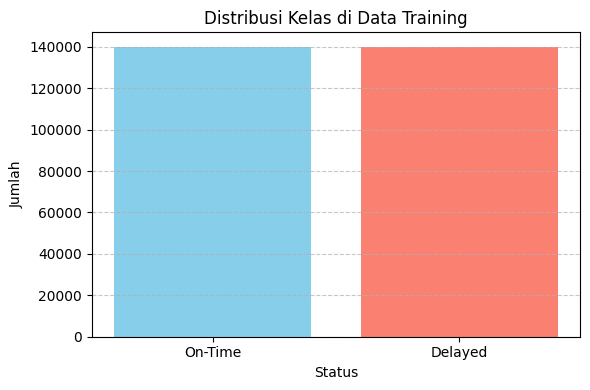

In [44]:
from collections import Counter

# Hitung distribusi kelas
label_counts = Counter(y_train)
labels = ['On-Time', 'Delayed']
counts = [label_counts[0], label_counts[1]]

# Plot bar
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color=['skyblue', 'salmon'])
plt.title('Distribusi Kelas di Data Training')
plt.xlabel('Status')
plt.ylabel('Jumlah')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [45]:
from sklearn.decomposition import TruncatedSVD

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train_scaled.toarray()
X_val_scaled = X_val_scaled.toarray()
X_test_scaled = X_test_scaled.toarray()

print(X_train_scaled.shape) 

(279979, 1801)


In [46]:
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import numpy as np

pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [47]:
import pandas as pd
from sklearn.metrics import accuracy_score
        
results = []
best_model = None
best_model_name = None
best_val_score = 0

print("\n=== Training Machine Learning Models ===")
for name, model in classification_models.items():
    try:
        print(f"Training {name}...")
        start_time = time.time()

        # Train model
        model.fit(X_train_pca, y_train)
        elapsed = time.time() - start_time

        # Predict
        y_train_pred = model.predict(X_train_pca)
        y_val_pred = model.predict(X_val_pca)
        y_test_pred = model.predict(X_test_pca)

        # Accuracy
        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        
        # Metrics
        acc = accuracy_score(y_val, y_val_pred)
        prec = precision_score(y_val, y_val_pred)
        rec = recall_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred)

        results.append([name, train_acc, val_acc, test_acc, prec, rec, f1, elapsed])

        print(f"{name} - Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f} | \
              Precision: {prec:.4f} | Recall: {rec:.4f} | F1 Score: {f1:.4f} | Time: {elapsed:.2f}s")

    except Exception as e:
        print(f"Error pada {name}: {e}")



=== Training Machine Learning Models ===
Training Bagging Classifier...


Bagging Classifier - Train Acc: 0.9839 | Val Acc: 0.7572 | Test Acc: 0.7559 |               Precision: 0.8294 | Recall: 0.6476 | F1 Score: 0.7273 | Time: 17609.47s
Training Logistic Regression...
Logistic Regression - Train Acc: 0.7839 | Val Acc: 0.7820 | Test Acc: 0.7819 |               Precision: 0.8875 | Recall: 0.6459 | F1 Score: 0.7477 | Time: 12.02s
Training GaussianNB...
GaussianNB - Train Acc: 0.5292 | Val Acc: 0.5305 | Test Acc: 0.5317 |               Precision: 0.5179 | Recall: 0.8831 | F1 Score: 0.6529 | Time: 6.43s
Training Random Forest...
Random Forest - Train Acc: 1.0000 | Val Acc: 0.7697 | Test Acc: 0.7682 |               Precision: 0.8518 | Recall: 0.6531 | F1 Score: 0.7393 | Time: 1983.39s
Training Decision Tree...
Decision Tree - Train Acc: 1.0000 | Val Acc: 0.6977 | Test Acc: 0.6952 |               Precision: 0.6950 | Recall: 0.7044 | F1 Score: 0.6997 | Time: 1046.44s
Training Gradient Boosting...
Gradient Boosting - Train Acc: 0.7755 | Val Acc: 0.7748 | Test Acc: 0

c:\Users\USER\OneDrive\Dokumen\Semester 4\AOL Data Analytics - Semester 4\tf-env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\USER\OneDrive\Dokumen\Semester 4\AOL Data Analytics - Semester 4\tf-env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\USER\OneDrive\Dokumen\Semester 4\AOL Data Analytics - Semester 4\tf-env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM - Train Acc: 0.7896 | Val Acc: 0.7827 | Test Acc: 0.7807 |               Precision: 0.8875 | Recall: 0.6474 | F1 Score: 0.7487 | Time: 63.51s


In [48]:
results_df = pd.DataFrame(results, columns=["Model", "Train Acc", "Val Acc", "Test Acc", "Precision", "Recall", "F1-Score", "Train Time (s)"])
print("\n=== Ringkasan Hasil ===")
display(results_df.sort_values("Val Acc", ascending=False))


=== Ringkasan Hasil ===


Model  Train Acc   Val Acc  Test Acc  Precision    Recall  \
9             LightGBM   0.789570  0.782659  0.780711   0.887510  0.647382   
1  Logistic Regression   0.783877  0.782034  0.781861   0.887530  0.645932   
7              XGBoost   0.822833  0.779908  0.779024   0.858387  0.670434   
5    Gradient Boosting   0.775487  0.774833  0.773686   0.879934  0.636532   
3        Random Forest   0.999986  0.769733  0.768198   0.851823  0.653083   
8                XGBRF   0.761650  0.761757  0.757485   0.897434  0.591080   
0   Bagging Classifier   0.983902  0.757207  0.755922   0.829448  0.647582   
6             AdaBoost   0.748906  0.749356  0.745872   0.788166  0.682034   
4        Decision Tree   0.999986  0.697652  0.695231   0.695017  0.704435   
2           GaussianNB   0.529183  0.530540  0.531721   0.517918  0.883094   

   F1-Score  Train Time (s)  
9  0.748663       63.507046  
1  0.747699       12.022280  
7  0.752857      136.991289  
5  0.738699    14929.688928  
3  0.739330     1983.385960  
8  0.712731      139.395139  
0  0.727319    17609.474188  
6  0.731269     3137.003448  
4  0.699695     1046.435800  
2  0.652914        6.426768

In [49]:
print(X_train_pca.shape, X_val_pca.shape, X_test_pca.shape)


(279979, 894) (39997, 894) (79995, 894)


In [50]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2


# Neural Network Model
model_nn = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_pca.shape[1],)),
    layers.Dropout(0.4),
    
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.4),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.4),

    
    layers.Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model_nn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
print(X_train_pca.shape, X_val_pca.shape, X_test_pca.shape)


(279979, 894) (39997, 894) (79995, 894)


In [52]:
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               114560    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [53]:
from tensorflow.keras.models import load_model

history = model_nn.fit(
    X_train_pca, y_train, 
    epochs=100, 
    validation_data=(X_val_pca, y_val), 
    batch_size=32, 
    verbose=1,
    )

model_nn.save(r"C:\Users\USER\OneDrive\Dokumen\Semester 4\AOL Data Analytics - Semester 4\result_dataset\model_nn.h5")

test_loss, test_acc = model_nn.evaluate(X_test_pca, y_test)
print(f"Neural Network Test Accuracy: {test_acc:.4f}")


Epoch 1/100


8750/8750 [==============================] - 29s 3ms/step - loss: 0.5185 - accuracy: 0.7527 - val_loss: 0.4616 - val_accuracy: 0.7748
Epoch 2/100
8750/8750 [==============================] - 25s 3ms/step - loss: 0.4683 - accuracy: 0.7728 - val_loss: 0.4551 - val_accuracy: 0.7767
Epoch 3/100
8750/8750 [==============================] - 25s 3ms/step - loss: 0.4616 - accuracy: 0.7772 - val_loss: 0.4538 - val_accuracy: 0.7762
Epoch 4/100
8750/8750 [==============================] - 26s 3ms/step - loss: 0.4594 - accuracy: 0.7786 - val_loss: 0.4517 - val_accuracy: 0.7813
Epoch 5/100
8750/8750 [==============================] - 26s 3ms/step - loss: 0.4565 - accuracy: 0.7797 - val_loss: 0.4516 - val_accuracy: 0.7793
Epoch 6/100
8750/8750 [==============================] - 24s 3ms/step - loss: 0.4551 - accuracy: 0.7810 - val_loss: 0.4541 - val_accuracy: 0.7800
Epoch 7/100
8750/8750 [==============================] - 25s 3ms/step - loss: 0.4530 - accuracy: 0.7825 - val_loss: 0.4504

c:\Users\USER\OneDrive\Dokumen\Semester 4\AOL Data Analytics - Semester 4\tf-env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2500/2500 [==============================] - 7s 3ms/step - loss: 0.4560 - accuracy: 0.7803
Neural Network Test Accuracy: 0.7803


In [54]:
import numpy as np
import time
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

start_time = time.time()

train_loss, train_acc = model_nn.evaluate(X_train_pca, y_train, verbose=0)
val_loss, val_acc = model_nn.evaluate(X_val_pca, y_val, verbose=0)
test_loss, test_acc = model_nn.evaluate(X_test_pca, y_test, verbose=0)

y_val_pred_prob = model_nn.predict(X_val_pca)
y_val_pred = (y_val_pred_prob > 0.5).astype(int).flatten()

prec = precision_score(y_val, y_val_pred)
rec = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

elapsed = time.time() - start_time

results.append([
    "Neural Network", 
    train_acc, val_acc, test_acc, 
    prec, rec, f1, elapsed
])

results_df = pd.DataFrame(results, columns=[
    "Model", "Train Accuracy", "Validation Accuracy", "Test Accuracy", 
    "Precision", "Recall", "F1-Score", "Training Time (s)"
])
results_df[[
    "Train Accuracy", "Validation Accuracy", "Test Accuracy", 
    "Precision", "Recall", "F1-Score"
]] = results_df[[
    "Train Accuracy", "Validation Accuracy", "Test Accuracy", 
    "Precision", "Recall", "F1-Score"
]].round(4)

results_df.to_csv(
    r"C:\Users\USER\OneDrive\Dokumen\Semester 4\AOL Data Analytics - Semester 4\result_dataset\model_results.csv", 
    index=False
)
results_df.to_json(
    r"C:\Users\USER\OneDrive\Dokumen\Semester 4\AOL Data Analytics - Semester 4\result_dataset\model_results.json", 
    orient="records"
)

print("\n=== Hasil Akurasi Model ===")
print(results_df.to_string(index=False))


1250/1250 [==============================] - 4s 2ms/step

=== Hasil Akurasi Model ===
              Model  Train Accuracy  Validation Accuracy  Test Accuracy  Precision  Recall  F1-Score  Training Time (s)
 Bagging Classifier          0.9839               0.7572         0.7559     0.8294  0.6476    0.7273       17609.474188
Logistic Regression          0.7839               0.7820         0.7819     0.8875  0.6459    0.7477          12.022280
         GaussianNB          0.5292               0.5305         0.5317     0.5179  0.8831    0.6529           6.426768
      Random Forest          1.0000               0.7697         0.7682     0.8518  0.6531    0.7393        1983.385960
      Decision Tree          1.0000               0.6977         0.6952     0.6950  0.7044    0.6997        1046.435800
  Gradient Boosting          0.7755               0.7748         0.7737     0.8799  0.6365    0.7387       14929.688928
           AdaBoost          0.7489               0.7494         0.7459   

In [56]:
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from scipy.stats import uniform, randint

X_train_pca = X_train_pca.astype(np.float32)
X_val_pca = X_val_pca.astype(np.float32)
X_test_pca = X_test_pca.astype(np.float32)

param_distributions = {
    'learning_rate': uniform(0.01, 0.1),      
    'max_depth': randint(3, 10),              
    'n_estimators': randint(100, 300)        
}

lgbm = LGBMClassifier(random_state=42,n_jobs=1)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

halving_search = HalvingRandomSearchCV(
    estimator=lgbm,
    param_distributions=param_distributions,
    cv=cv,
    factor=3,              
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1,
    error_score='raise'
)

print("Melakukan Hyperparameter Tuning dengan HalvingRandomSearchCV pada LightGBM")
halving_search.fit(X_train_pca, y_train)

best_model = halving_search.best_estimator_
print("Model terbaik dari HalvingRandomSearchCV:")
print(best_model)

val_preds = best_model.predict(X_val_pca)
best_val_score = accuracy_score(y_val, val_preds)
print("Skor validasi terbaik:", best_val_score)

test_preds = best_model.predict(X_test_pca)
test_score = accuracy_score(y_test, test_preds)
print("Skor akurasi di test set:", test_score)


Melakukan Hyperparameter Tuning dengan HalvingRandomSearchCV pada LightGBM
n_iterations: 10
n_required_iterations: 10
n_possible_iterations: 10
min_resources_: 12
max_resources_: 279979
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 23331
n_resources: 12
Fitting 3 folds for each of 23331 candidates, totalling 69993 fits
----------
iter: 1
n_candidates: 7777
n_resources: 36
Fitting 3 folds for each of 7777 candidates, totalling 23331 fits
----------
iter: 2
n_candidates: 2593
n_resources: 108
Fitting 3 folds for each of 2593 candidates, totalling 7779 fits
----------
iter: 3
n_candidates: 865
n_resources: 324
Fitting 3 folds for each of 865 candidates, totalling 2595 fits
----------
iter: 4
n_candidates: 289
n_resources: 972
Fitting 3 folds for each of 289 candidates, totalling 867 fits
----------
iter: 5
n_candidates: 97
n_resources: 2916
Fitting 3 folds for each of 97 candidates, totalling 291 fits
----------
iter: 6
n_candidates: 33
n_resources: 8748
Fitting

c:\Users\USER\OneDrive\Dokumen\Semester 4\AOL Data Analytics - Semester 4\tf-env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Skor validasi terbaik: 0.7788834162562193


c:\Users\USER\OneDrive\Dokumen\Semester 4\AOL Data Analytics - Semester 4\tf-env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Skor akurasi di test set: 0.7766610413150822


In [ ]:
y_val_pred = lgbm.predict(X_val_pca)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nAkurasi pada Validation Set: {val_accuracy:.4f}")
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))

y_test_pred = lgbm.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nAkurasi pada Test Set: {test_accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

NameError: name 'LGBMClassifier' is not defined

In [ ]:
y_pred = best_model.predict(X_test_pca)

predictions_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

print(predictions_df.head(10))

predictions_df['Correct'] = (predictions_df['Actual'] == predictions_df['Predicted'])
correct_count = predictions_df['Correct'].sum()
print(f"Total correct predictions:{correct_count} dari {len(predictions_df)} data")

with open(r"C:\Users\USER\OneDrive\Dokumen\Semester 4\AOL Data Analytics - Semester 4\result_dataset\xgbboost_class_model.pkl", "wb") as file:
    pickle.dump(best_model, file)
print("Model terbaik telah disimpan sebagai 'ligthgbm_class_model.pkl'")

predictions_df.to_csv(r"C:\Users\USER\OneDrive\Dokumen\Semester 4\AOL Data Analytics - Semester 4\result_dataset\xgbboost_prediksi.csv", index=False)
print("Hasil prediksi telah disimpan sebagai 'ligthgbm_prediksi.csv'")


c:\Users\USER\OneDrive\Dokumen\Semester 4\AOL Data Analytics - Semester 4\tf-env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   Actual  Predicted
0       0          0
1       0          0
2       0          0
3       0          0
4       1          1
5       0          0
6       0          0
7       0          0
8       0          0
9       0          0
Total correct predictions:62129 dari 79995 data
Model terbaik telah disimpan sebagai 'xgbboost_class_model.pkl'
Hasil prediksi telah disimpan sebagai 'xgbboost_prediksi.csv'


In [59]:
y_pred = best_model.predict(X_test_pca)

predictions_df = pd.DataFrame({
    "Airline": airline_test,
    "Actual": y_test,
    "Predicted": y_pred
})

predictions_df["Correct"] = (predictions_df["Actual"] == predictions_df["Predicted"]).astype(int)  # 1 = benar, 0 = salah

maskapai_summary = predictions_df.groupby("Airline").agg(
    Total=('Correct', 'count'),
    Benar=('Correct', 'sum'),
    Salah=('Correct', lambda x: (1 - x).sum())
)

maskapai_summary["Accuracy (%)"] = 100 * maskapai_summary["Benar"] / maskapai_summary["Total"]
maskapai_summary = maskapai_summary.sort_values(by="Accuracy (%)", ascending=False)

print("\n=== Contoh 10 Prediksi ===")
print(predictions_df.head(10)) 


print("\n=== Akurasi per Maskapai ===")
print(maskapai_summary)

c:\Users\USER\OneDrive\Dokumen\Semester 4\AOL Data Analytics - Semester 4\tf-env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Contoh 10 Prediksi ===
                             Airline  Actual  Predicted  Correct
49219         Southwest Airlines Co.       0          0        1
321922         United Air Lines Inc.       0          0        1
338612           Delta Air Lines Inc       0          0        1
157337        American Airlines Inc.       0          0        1
60246           Alaska Airlines Inc.       1          1        1
159298                 Allegiant Air       0          0        1
231301  American Eagle Airlines Inc.       0          0        1
78435         Southwest Airlines Co.       0          0        1
175101        American Airlines Inc.       0          0        1
287376        American Airlines Inc.       0          0        1

=== Akurasi per Maskapai ===
                              Total  Benar  Salah  Accuracy (%)
Airline                                                        
Republic Airways               3013   2602    411     86.359111
Endeavor Air                   2214

Confusion Matrix

c:\Users\USER\OneDrive\Dokumen\Semester 4\AOL Data Analytics - Semester 4\tf-env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


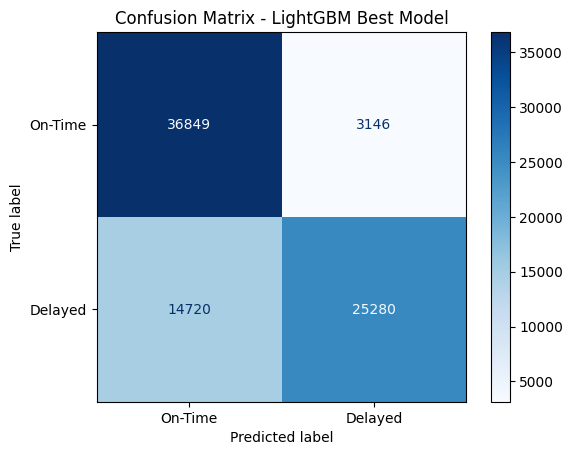

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prediksi label dari test set menggunakan best_model
test_preds = best_model.predict(X_test_pca)

# Hitung confusion matrix
cm = confusion_matrix(y_test, test_preds)

# Tampilkan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["On-Time", "Delayed"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - LightGBM Best Model")
plt.show()



Overfitting Analysis

c:\Users\USER\OneDrive\Dokumen\Semester 4\AOL Data Analytics - Semester 4\tf-env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Train Accuracy     : 0.7824
Validation Accuracy: 0.7789
Test Accuracy      : 0.7767
Train - Val gap    : 0.0035
Val - Test gap     : 0.0022
Model cukup seimbang antara training dan validation.

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.71      0.92      0.80     39995
           1       0.89      0.63      0.74     40000

    accuracy                           0.78     79995
   macro avg       0.80      0.78      0.77     79995
weighted avg       0.80      0.78      0.77     79995



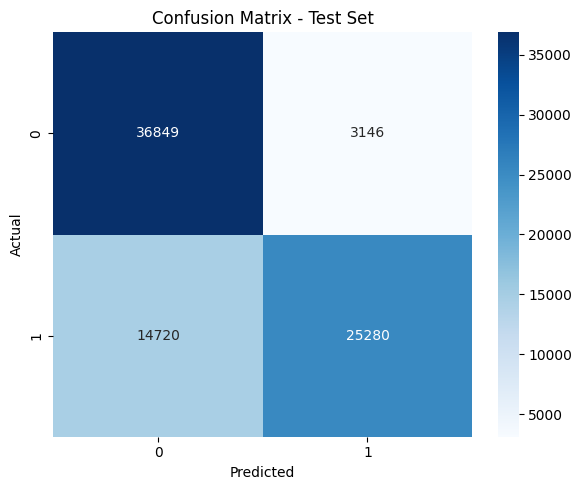

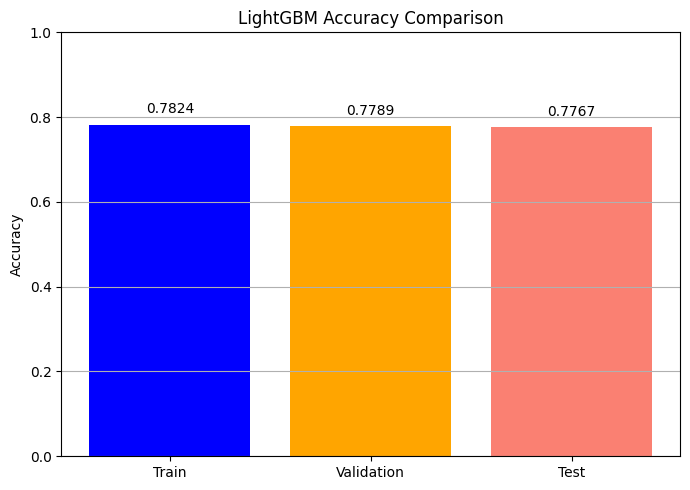

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Evaluasi Akurasi
train_preds = best_model.predict(X_train_pca)
train_acc = accuracy_score(y_train, train_preds)
val_acc = accuracy_score(y_val, val_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f"Train Accuracy     : {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy      : {test_acc:.4f}")

# 2. Cek Potensi Overfitting
gap_train_val = train_acc - val_acc
gap_val_test = val_acc - test_acc

print(f"Train - Val gap    : {gap_train_val:.4f}")
print(f"Val - Test gap     : {gap_val_test:.4f}")

if gap_train_val > 0.03:
    print("Model kemungkinan overfitting ke training data.")
elif gap_train_val < -0.03:
    print("Model underfitting, mungkin terlalu sederhana.")
else:
    print("Model cukup seimbang antara training dan validation.")

# 3. Confusion Matrix & Classification Report (Test Set)
print("\nClassification Report (Test Set):")
print(classification_report(y_test, test_preds))

# 4. Confusion Matrix Visual
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, test_preds), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 5. Bar Chart Accuracy
plt.figure(figsize=(7, 5))
accuracy_values = [train_acc, val_acc, test_acc]
labels = ['Train', 'Validation', 'Test']
colors = ['blue', 'orange', 'salmon']

plt.bar(labels, accuracy_values, color=colors)
plt.ylim(0, 1)
plt.title("LightGBM Accuracy Comparison")
plt.ylabel("Accuracy")
plt.grid(axis='y')

for i, acc in enumerate(accuracy_values):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()



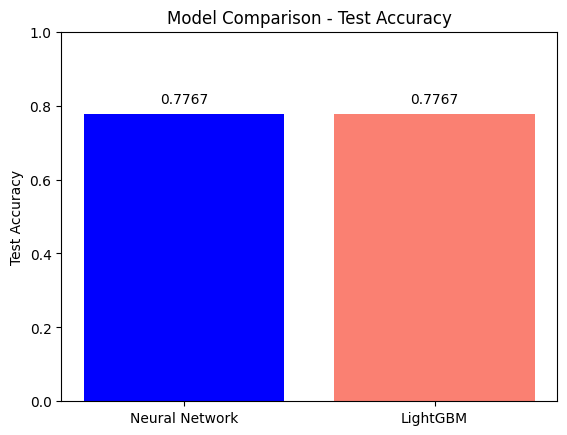

In [62]:
models = ['Neural Network', 'LightGBM']
accuracies = [test_acc, test_score]  # test_acc dari model_nn, test_score dari best_model

plt.bar(models, accuracies, color=['blue', 'salmon'])
plt.ylabel("Test Accuracy")
plt.title("Model Comparison - Test Accuracy")
plt.ylim(0, 1)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha='center', va='bottom', fontsize=10)

plt.show()
